#### Import data and librarys

In [26]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv("agg.csv")

#### Model

In [28]:
df["updated_at"] = pd.to_datetime(df["updated_at"])
df = df.sort_values(["number", "updated_at"])
df["ratio"] = df["available_to_total_ratio"].astype(float)
df["hour"] = df["updated_at"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["minute"] = df["updated_at"].dt.minute
df["weekday_num"] = df["updated_at"].dt.weekday
df["is_weekend"] = (df["is_weekend"].astype(str).str.strip().str.lower().replace({"false": 0, "true": 1}))
df["is_weekend"] = df["is_weekend"].fillna(0)
df["is_weekend"] = df["is_weekend"].astype(int)

/tmp/ipython-input-851586395.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_weekend"] = (df["is_weekend"].astype(str).str.strip().str.lower().replace({"false": 0, "true": 1}))


In [29]:
from sklearn.model_selection import train_test_split
SEQ_LEN = 144
PRED_LEN = 144 # Define the number of future timesteps to predict

def build_sequences(group):
    X, y = [], []
    data = group[["ratio", "geo_point_2d.lon", "geo_point_2d.lat", "hour_sin", "hour_cos", "weekday_num", "is_weekend"]].values
    for i in range(len(data) - SEQ_LEN - PRED_LEN):
        X.append(data[i:i+SEQ_LEN])
        # Predict a sequence of 'PRED_LEN' future ratios
        y.append(data[i+SEQ_LEN : i+SEQ_LEN+PRED_LEN, 0])
    return np.array(X), np.array(y)

X_list, y_list = [], []

for station_id, g in df.groupby("number"):
    Xi, yi = build_sequences(g)
    X_list.append(Xi)
    y_list.append(yi)

X = np.vstack(X_list)
y = np.concatenate(y_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (56240, 144, 7), y_train shape: (56240, 144)
X_test shape: (14060, 144, 7), y_test shape: (14060, 144)


In [30]:
class BikeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

train_ds = BikeDataset(X_train, y_train)
val_ds = BikeDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


In [59]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, feature_dim=32, hidden_dim=64, output_len=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(input_dim, feature_dim),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(feature_dim, feature_dim),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.gru = nn.GRU(feature_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_len),
            nn.Sigmoid()
        )

    def forward(self, x):
        output, _ = self.gru(self.features(x))
        last = output[:, -1, :]
        return self.fc(last)

model = GRUModel(input_dim=X.shape[2], feature_dim=256, hidden_dim=256, output_len=PRED_LEN) # Pass PRED_LEN to output layer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_ds.to(device)
val_ds.to(device)
print(f"Using device: {device}")

Using device: cuda


#### Training

In [62]:
from tqdm.notebook import tqdm
full_train_loss = 0
full_val_loss = 0

best_val_loss = float('inf')
patience = 5
counter = 0
optimal_state_dict = None

pbar = tqdm(range(100), desc="Epoch", postfix=f"train_loss={full_train_loss}, val_loss={full_val_loss}")
for epoch in pbar:
    model.train()
    train_loss = 0
    train_count = 0
    for Xb, yb in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        pred = model(Xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    full_train_loss = train_loss / train_count

    model.eval()
    val_loss = 0
    val_count = 0
    with torch.no_grad():
        for Xb, yb in tqdm(val_loader, desc="Validating", leave=False):
            pred = model(Xb).squeeze()
            val_loss += criterion(pred, yb).item()
            val_count += 1
    full_val_loss = val_loss / val_count
    pbar.set_postfix(train_loss=full_train_loss, val_loss=full_val_loss)
    if full_val_loss < best_val_loss:
        best_val_loss = full_val_loss
        optimal_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
model.load_state_dict(optimal_state_dict)


Epoch:   0%|          | 0/100 [00:00<?, ?it/s, train_loss=0, val_loss=0]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Training:   0%|          | 0/879 [00:00<?, ?it/s]

Validating:   0%|          | 0/220 [00:00<?, ?it/s]

Early stopping triggered


<All keys matched successfully>

#### Use historical data to predict the next 24 hours

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def predict_next_24_hours(station):
    df1 = df[df["number"] == station].copy()
    df1 = df1.sort_values("updated_at")

    last_ts = df1["updated_at"].max()
    cutoff = last_ts - pd.Timedelta(hours=24)

    df_hist = df1[df1["updated_at"] < cutoff].copy()
    df_future = df1[df1["updated_at"] >= cutoff].copy()

    features = ["ratio", "geo_point_2d.lon", "geo_point_2d.lat", "hour_sin", "hour_cos", "weekday_num", "is_weekend"]
    hist_vals = df_hist[features].values
    X_window = hist_vals[-SEQ_LEN:].copy()
    X_window = torch.tensor(X_window, dtype=torch.float32).unsqueeze(0)
    X_window = X_window.to(device)

    preds = []

    baseline_ratio = df_hist["ratio"].mean()
    baseline_preds_ratio = np.ones(len(df_future)) * baseline_ratio

    model.eval()
    with torch.no_grad():
        """for i in range(len(df_future)):

            pred = model(X_window).cpu().numpy().flatten()[0]
            preds.append(pred)

            next_feat = np.array([
                pred,
                df_future.iloc[i]["geo_point_2d.lon"],
                df_future.iloc[i]["geo_point_2d.lat"],
                df_future.iloc[i]["hour_sin"],
                df_future.iloc[i]["hour_cos"],
                df_future.iloc[i]["weekday_num"],
                df_future.iloc[i]["is_weekend"]
            ], dtype=float)

            next_feat = torch.tensor(next_feat, dtype=torch.float32, device=device)

            X_window = torch.cat([X_window[:, 1:, :], next_feat.view(1, 1, -1)], dim=1)"""
        preds = model(X_window).cpu().numpy().flatten()
    true_ratio = df_future["ratio"].values[:len(preds)]
    times = df_future["updated_at"].values[:len(preds)]

    return preds, true_ratio, times, baseline_preds_ratio

def calculate_metrics(preds, true_ratio):
    mae = mean_absolute_error(true_ratio, preds)
    rmse = np.sqrt(mean_squared_error(true_ratio, preds))
    r2 = r2_score(true_ratio, preds)
    return mae, rmse, r2

def plot_predictions(station, preds, true_ratio, times, baseline_preds_ratio):
    plt.figure(figsize=(12,5))
    plt.plot(times, true_ratio, label="Observations (ratio)")
    plt.plot(times, preds, label="Autoregressive prediction (GRU)", linestyle="--")
    plt.plot(times, baseline_preds_ratio, label="Baseline", linestyle=":")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Ratio avalible bici")
    plt.title(f"Station {station}: GRU vs baseline")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

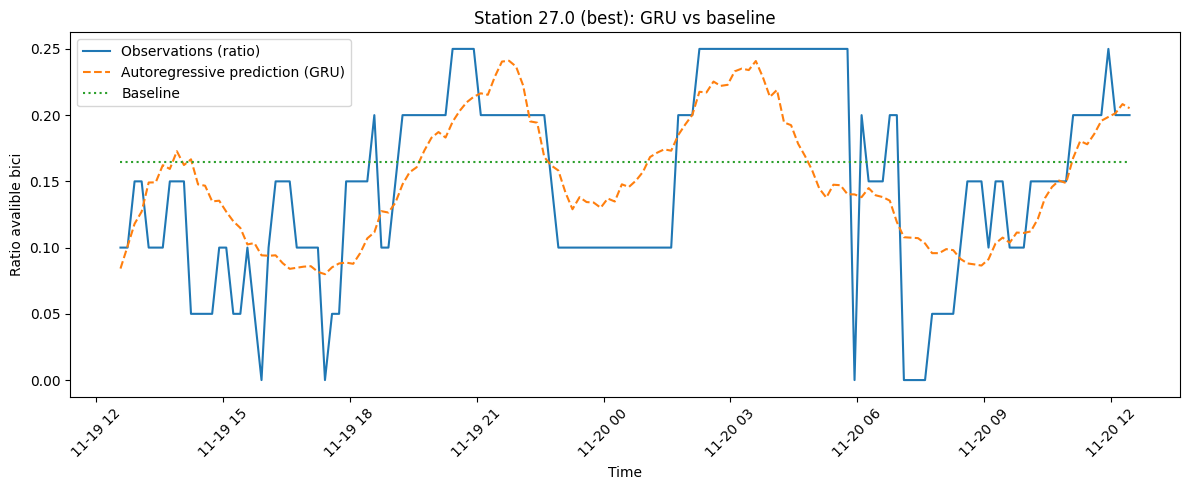

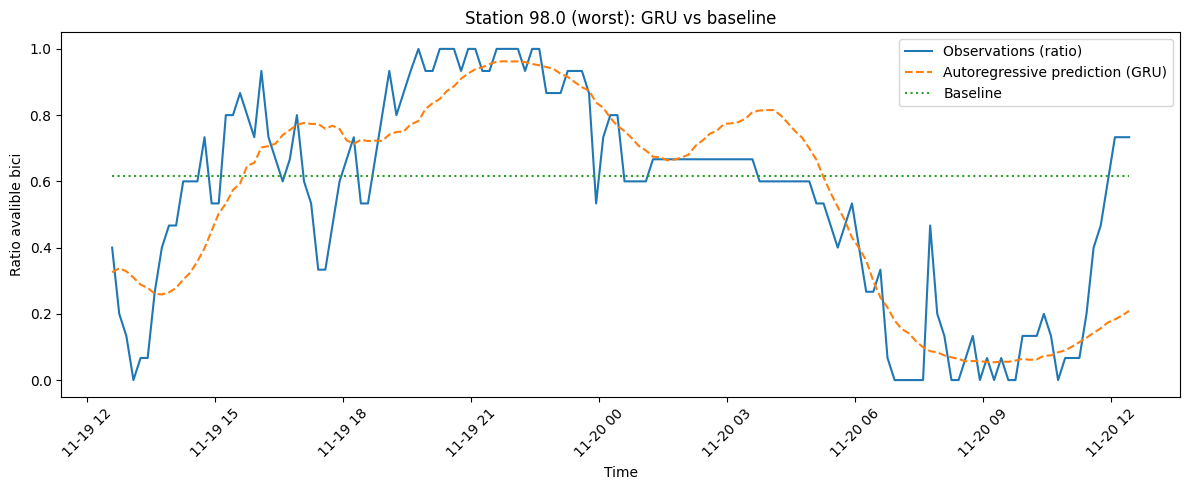

Overall MAE for best station 27.0: 0.0519
Overall MAE for worst station 98.0: 0.1681


In [72]:
results_df = pd.DataFrame() # Initialize an empty DataFrame

for station in df["number"].unique():
    preds, true_ratio, times, baseline_preds_ratio = predict_next_24_hours(station)
    mae, rmse, r2 = calculate_metrics(preds, true_ratio)

    # Create a temporary DataFrame for the current station's predictions
    # Each row will correspond to a single time step within the prediction window
    temp_df = pd.DataFrame({
        "station": [station] * len(preds), # Repeat station ID for each prediction step
        "preds": preds,
        "true": true_ratio,
        "times": times,
        "baseline": baseline_preds_ratio,
        "mae": [mae] * len(preds), # Repeat metrics for each prediction step
        "rmse": [rmse] * len(preds),
        "r2": [r2] * len(preds)
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Now, results_df has multiple rows per station, each representing a prediction at a specific time.
# To find the best/worst station, we group by station and consider the calculated metrics.
# Since mae, rmse, r2 are already stored for each row of a station, we can simply get the first occurrence for each station.
station_metrics = results_df.drop_duplicates(subset=['station'])[['station', 'mae', 'rmse', 'r2']]

best_station_row = station_metrics.loc[station_metrics["rmse"].idxmin()]
worst_station_row = station_metrics.loc[station_metrics["rmse"].idxmax()]

best_station_id = best_station_row["station"]
worst_station_id = worst_station_row["station"]

# Filter the original results_df to get all prediction data for the best and worst stations
best_plot_data = results_df[results_df["station"] == best_station_id]
worst_plot_data = results_df[results_df["station"] == worst_station_id]

# Plotting the predictions for the best and worst performing stations
plot_predictions(f"{best_station_id} (best)",
                 best_plot_data["preds"].values,
                 best_plot_data["true"].values,
                 best_plot_data["times"].values,
                 best_plot_data["baseline"].values)

plot_predictions(f"{worst_station_id} (worst)",
                 worst_plot_data["preds"].values,
                 worst_plot_data["true"].values,
                 worst_plot_data["times"].values,
                 worst_plot_data["baseline"].values)

print(f"Overall MAE for best station {best_station_id}: {best_station_row['rmse']:.4f}")
print(f"Overall MAE for worst station {worst_station_id}: {worst_station_row['rmse']:.4f}")

In [73]:
station_coords = df[['number', 'geo_point_2d.lat', 'geo_point_2d.lon']].drop_duplicates()

merged_data = pd.merge(station_coords, station_metrics, left_on='number', right_on='station', how='inner')

print("Station Coordinates:")
print(station_coords.head())
print("\nMerged Data with Coordinates and Metrics:")
print(merged_data.head())

Station Coordinates:
   number  geo_point_2d.lat  geo_point_2d.lon
0       1         39.480042         -0.382929
1       2         39.479889         -0.379748
2       3         39.476835         -0.380288
3       4         39.476747         -0.375342
4       5         39.476895         -0.371140

Merged Data with Coordinates and Metrics:
   number  geo_point_2d.lat  geo_point_2d.lon  station       mae      rmse  \
0       1         39.480042         -0.382929        1  0.060910  0.091732   
1       2         39.479889         -0.379748        2  0.098790  0.128951   
2       3         39.476835         -0.380288        3  0.086610  0.110601   
3       4         39.476747         -0.375342        4  0.084184  0.107371   
4       5         39.476895         -0.371140        5  0.103646  0.129743   

         r2  
0  0.564077  
1 -0.036082  
2  0.582813  
3  0.724311  
4  0.476364  


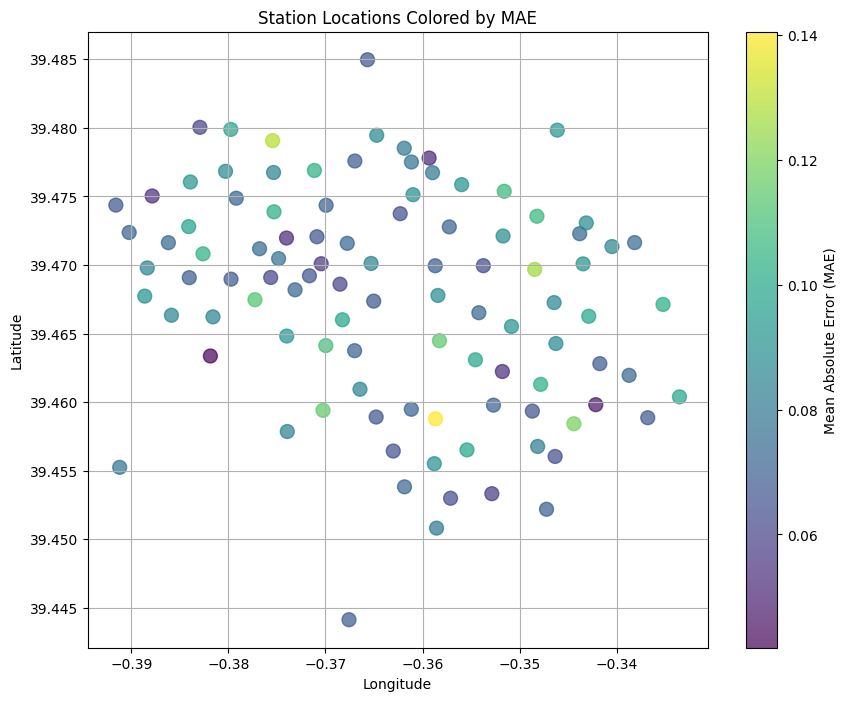

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(merged_data['geo_point_2d.lon'], merged_data['geo_point_2d.lat'],
                      c=merged_data['mae'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Mean Absolute Error (MAE)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station Locations Colored by MAE')
plt.grid(True)
plt.show()

In [75]:
import folium

# Calculate the center of the map based on the average coordinates
center_lat = merged_data['geo_point_2d.lat'].mean()
center_lon = merged_data['geo_point_2d.lon'].mean()

# Create a Folium map centered at the average coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Normalize MAE for color and size scaling
# Using a min-max scaler to normalize MAE between 0 and 1
min_mae = merged_data['mae'].min()
max_mae = merged_data['mae'].max()

# Add CircleMarkers for each station
for idx, row in merged_data.iterrows():
    # Scale MAE for color (e.g., green for low MAE, red for high MAE)
    # Using a simple linear interpolation for color based on MAE
    norm_mae = (row['mae'] - min_mae) / (max_mae - min_mae) if (max_mae - min_mae) > 0 else 0
    color = plt.cm.viridis(norm_mae) # Get color from viridis colormap
    # Convert RGBA to hex for Folium
    hex_color = '#%02x%02x%02x' % (int(color[0]*255), int(color[1]*255), int(color[2]*255))

    folium.CircleMarker(
        location=[row['geo_point_2d.lat'], row['geo_point_2d.lon']],
        radius=5,
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
        tooltip=f"Station: {int(row['station'])}, MAE: {row['mae']:.4f}"
    ).add_to(m)

# Display the map
m

In [76]:
torch.save(model.state_dict(), "gru_bike_prediction_model.pt")
print("Model saved to gru_bike_prediction_model.pt")

Model saved to gru_bike_prediction_model.pt
